<a href="https://colab.research.google.com/github/Ashish3241/PRODIGY/blob/main/PRODIGY_GA_02_Image_Generation_using_Stylegan_pre_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ffhq-face-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F379454%2F735991%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T044230Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcd9ad6a2f5594b384f8b19b33902c5ec51ce21707fa5713627935bb7850121574653433b2393b5fa1f0fb6bd978ea438d08d34384c50e4e24e3b264c9af504fc296238d455cd5ac349987b4b846e66561ff5556ea6710f0644c83fc6c06f60c09abcfad10874f0a26a48c4822cdd9e92f6db432133581ccf3e6760708dfed594ef04cbdf398c97c80b9eae18336c00d7b9e00ca355a197818aa118fe7c3646849b96b680d9b48e522a7a5a754ebd27fb495fb23ac4cd426cc4082d1a74cbdff4cb63511cd1539a27a8487e99784183bb9c8b9f211a41c543ec81cc15366ee497af46f13a74706b6a5ad91eca89121144515a4cc4c9a7654e7e782fc07ba64541,ffhq-1024x1024-pretrained:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1429020%2F2365676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T044230Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1f6641d067c712607e7718642535f63cf9f0c6994385d63e1651565b5ce724a07a1f2b79da5a46719ef1c391c77313d9e857bd9a3fa5ef45d917f45d951474a12e014f9274a3dda4790acf5cb0966e9165a803919cceaee7462dd0fca01a20258101d5b6f4780a9ca9a06e921aa50de282ff5c2d2de9844d0b32b3bd2650c06bb69e4ad8a3837abb532437f45aaa5183ae178f3a50b982f94fd9d07352215a4fb825a09a49c4d17215045a55e7e7217c221bce7b70f0b5b59e7ce64da3cc5b068698e388290e52805b5f296f2c785fa1a5af3e651f923f6da39849a9d1adfa45d37f79995fd0dd252536e4e6a7cb1fb6ac1f89373b682ea079320820c28ecf8c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2113829047 bytes downloaded
Downloaded and uncompressed: ffhq-face-data-set
[==================================================] 97340054 bytes downloaded
Downloaded and uncompressed: ffhq-1024x1024-pretrained
Data source import complete.


# Image Generation using Stylegan pre-trained model

### Step 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle

import numpy as np

import IPython

### Step 2. Design Layers

**2-a. Linear Layer**

In [ ]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)


> TEST CODE :

In [ ]:
gain = 2**(0.5)
gain

1.4142135623730951

In [ ]:
he_std = gain*(512**(-0.5)) # input_size = 512
he_std

0.06250000000000001

In [ ]:
lrmul = 1
init_std = 1.0/lrmul
print(init_std)
print('w_mul when use wscale :',he_std*init_std)

1.0
w_mul when use wscale : 0.06250000000000001


In [ ]:
torch.randn(512,512)*init_std

tensor([[-0.0299,  0.7832,  1.4377,  ..., -0.1455, -0.5897, -0.5526],
        [-0.6166, -0.5769,  1.2748,  ...,  0.5413, -0.0150,  1.2057],
        [-1.9066, -2.1370, -0.1771,  ...,  0.7775,  0.3097,  3.2620],
        ...,
        [ 0.0674,  0.9884,  0.4861,  ..., -0.5522,  0.7082, -1.0567],
        [ 1.8809, -0.3700, -1.6929,  ..., -0.8918, -0.6327,  0.2379],
        [-1.1819,  1.5280, -0.2335,  ...,  0.8027,  1.6008,  0.6590]])

In [ ]:
weight = torch.nn.Parameter(torch.randn(512,512)*init_std) # Parameter(..) ==> requires_grad=True
weight

Parameter containing:
tensor([[-0.0906,  0.4560, -0.5191,  ...,  0.1462, -0.1079,  0.1573],
        [-0.6073, -0.5097, -0.6724,  ..., -0.3426,  1.3766,  0.3139],
        [-2.3485,  1.3257,  2.0095,  ..., -0.1665, -0.5573,  0.2011],
        ...,
        [ 0.4670,  0.3769, -0.2378,  ..., -0.3090,  1.3870,  1.4835],
        [ 0.2127, -0.6847,  1.2161,  ...,  0.1914, -0.1272,  0.4641],
        [ 1.6076, -0.2805,  0.8864,  ..., -0.1360,  0.6216, -0.5612]],
       requires_grad=True)

In [ ]:
bias = torch.nn.Parameter(torch.zeros(512,512))
bias

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [ ]:
w_mul = lrmul
b_mul = lrmul

F.linear(torch.randn(512,512), weight*w_mul, bias*b_mul)

tensor([[ 36.4886,  10.9518, -12.1571,  ..., -29.7436,  21.3008,   6.9315],
        [ -4.1203,  14.5109,   5.6339,  ...,  -5.6733, -38.3052,  25.4783],
        [-18.0975,  -4.2576, -23.6757,  ..., -25.3846,  18.8847,   2.1891],
        ...,
        [  7.5703, -25.3010, -15.2855,  ...,  24.2495,   9.2826, -12.8028],
        [-15.5543,   7.7310, -36.8111,  ...,  16.5752, -44.0141,  -6.1074],
        [  6.7490, -45.9947, -18.7086,  ...,   6.6780,  14.9095,  32.9495]],
       grad_fn=<AddmmBackward0>)

**2-b. Convolution Layer**

In [ ]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul

        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)

        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)

        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

**2-c. Noise Layer**

In [ ]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None

    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

**2-d. Style Modification Layer**

In [ ]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)

    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

> TEST CODE :

In [ ]:
lin = MyLinear(512, 3*2, 1.0, use_wscale=True)

In [ ]:
latent1 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent2 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent = torch.cat([latent1,latent2], axis=0)

In [ ]:
latent.size()

**2-e. Pixel Normalization Layer**

In [ ]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

**2-f. Blur Layer**

In [ ]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride

    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x


**2-g. Upscaling Layer**

In [ ]:
def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

### Step 3. Design Networks

**3-a. Generator Mapping Network**

In [ ]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))

    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

In [ ]:
class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

**3-b. Generator Synthesis Blocks**

In [ ]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x

In [ ]:
class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [ ]:
class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

**3-c. Generator Synthesis Network**

In [ ]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):

        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))

            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))

    def forward(self, dlatents_in):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

### Step 4. Define the Model (Image Generator)

**4-a. data flow : z to image**

In [ ]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis())
]))


**4-b. load pre-trained weight**

In [ ]:
import os
os.listdir('../input/ffhq-1024x1024-pretrained')

['karras2019stylegan-ffhq-1024x1024.for_g_all.pt']

In [ ]:
g_all.load_state_dict(torch.load('../input/ffhq-1024x1024-pretrained/karras2019stylegan-ffhq-1024x1024.for_g_all.pt'))

<ipython-input-27-1657674c8d56>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g_all.load_state_dict(torch.load('../input/ffhq-1024x1024-pretrained/karras2019stylegan-ffhq

<All keys matched successfully>

### Step 5. Test the Model

**5-a. gpu setting**

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

**5-b. input setting - grid**

In [ ]:
nb_rows = 3
nb_cols = 3
nb_samples = nb_rows * nb_cols

**5-c. input setting - latent z**

In [ ]:
latents = torch.randn(nb_samples, 512, device=device)

In [ ]:
latents

tensor([[-0.1571, -0.0578, -0.8687,  ..., -0.4016,  2.6319,  0.9954],
        [ 0.5317,  0.0622,  0.1117,  ...,  0.0050, -0.7522, -0.4160],
        [-1.7709, -0.1837, -0.5652,  ..., -0.7259,  0.6039,  0.2541],
        ...,
        [-1.6896,  0.9816,  0.2270,  ...,  0.3319, -1.1175,  3.0988],
        [-0.0303, -1.1643, -0.2681,  ..., -0.1088,  0.4419,  0.4541],
        [-0.1076, -0.3302, -1.8089,  ..., -2.3143, -0.2588,  0.2833]])

In [ ]:
latents.shape

torch.Size([9, 512])

**5-d. show samples**

In [ ]:
import torchvision
import matplotlib.pyplot as plt

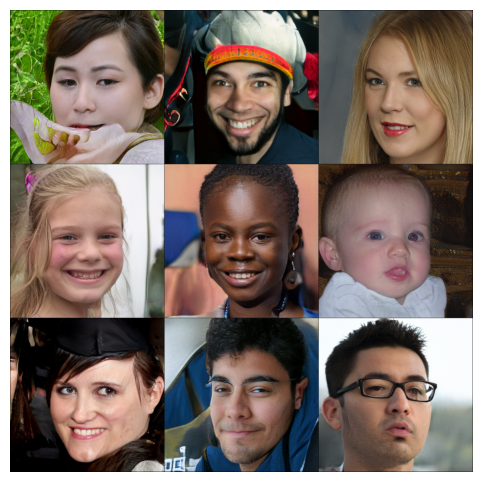

In [ ]:
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1)+1)/2.0  # normalization to 0~1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(15,6))
plt.imshow(imgs.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

### Step 6. Control Latent Vector

**6-a. first random latent vector + generate first image**

In [ ]:
latent1 = torch.randn(1, 512, device=device)
img1 = g_all(latent1)
img1 = img1.clamp(-1,1)+1/2.0
img1 = img1.cpu()

img1.shape

torch.Size([1, 3, 1024, 1024])

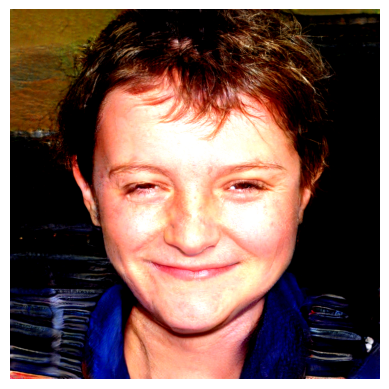

In [ ]:
plt.imshow(img1.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

**6-b. second random latent vector + generate second image**

In [ ]:
latent2 = torch.randn(1, 512, device=device)
img2 = g_all(latent2)
img2 = img2.clamp(-1,1)+1/2.0
img2 = img2.cpu()

img2.shape

torch.Size([1, 3, 1024, 1024])

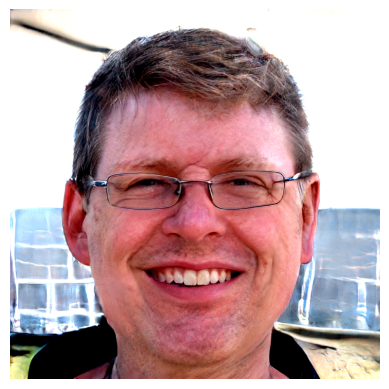

In [ ]:
plt.imshow(img2.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

In [ ]:
new_img = g_all(latent1*0.5 + latent2*0.5)
new_img = new_img.clamp(-1,1)+1/2.0
new_img = new_img.cpu()

new_img.shape

torch.Size([1, 3, 1024, 1024])

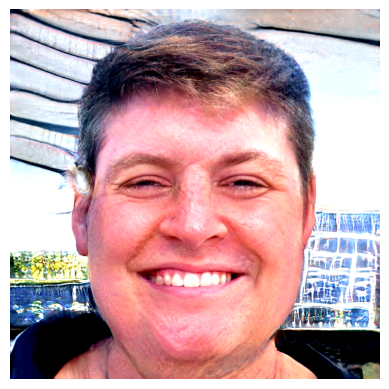

In [ ]:
plt.imshow(new_img.squeeze().permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

In [ ]:
g_mapping = g_all[0] # We can extract mapping network like this.
g_mapping

G_mapping(
  (pixel_norm): PixelNormLayer()
  (dense0): MyLinear()
  (dense0_act): LeakyReLU(negative_slope=0.2)
  (dense1): MyLinear()
  (dense1_act): LeakyReLU(negative_slope=0.2)
  (dense2): MyLinear()
  (dense2_act): LeakyReLU(negative_slope=0.2)
  (dense3): MyLinear()
  (dense3_act): LeakyReLU(negative_slope=0.2)
  (dense4): MyLinear()
  (dense4_act): LeakyReLU(negative_slope=0.2)
  (dense5): MyLinear()
  (dense5_act): LeakyReLU(negative_slope=0.2)
  (dense6): MyLinear()
  (dense6_act): LeakyReLU(negative_slope=0.2)
  (dense7): MyLinear()
  (dense7_act): LeakyReLU(negative_slope=0.2)
)

In [ ]:
g_synthesis = g_all[1]# Similarly, synthesis network can be extracted like this.

In [ ]:
w_1 = g_mapping(latent1)
w_2 = g_mapping(latent2)

The results through the MLP mapping network are as follows.

In [ ]:
print(latent1.size(), w_1.size())
print(latent2.size(), w_2.size())

torch.Size([1, 512]) torch.Size([1, 18, 512])
torch.Size([1, 512]) torch.Size([1, 18, 512])


then, let's convert to image (half + half)

In [ ]:
img3 = g_synthesis(w_1*0.5 + w_2*0.5)
img3 = img3.clamp(-1,1)+1/2.0
img3 = img3.cpu()

img3.shape

torch.Size([1, 3, 1024, 1024])

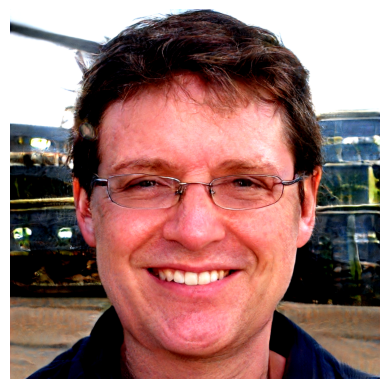

In [ ]:
plt.imshow(img3.squeeze().permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

**6-e. Image Interpolation Comparison**

In [ ]:
itp_imgs = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        z = ((1-a) * latent1) + (a * latent2)
        result = g_all(z)
        result = result.clamp(-1,1)+1/2.0
        result = result.cpu()
        itp_imgs.append(result)

In [ ]:
itp_imgs[0].size()

torch.Size([1, 3, 1024, 1024])

In [ ]:
itp_imgs = torch.cat(itp_imgs)
itp_imgs.size()

torch.Size([10, 3, 1024, 1024])

In [ ]:
grid_img = torchvision.utils.make_grid(itp_imgs, nrow=5)
grid_img.size()

torch.Size([3, 2054, 5132])

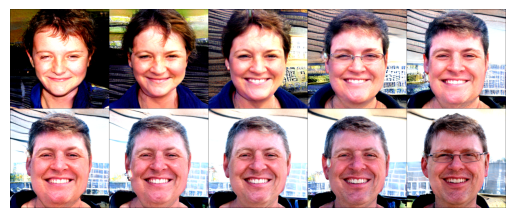

In [ ]:
plt.imshow(grid_img.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

In [ ]:
itp_imgs2 = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        w = ((1-a) * w_1) + (a * w_2)
        result2 = g_synthesis(w)
        result2 = result2.clamp(-1,1)+1/2.0
        result2 = result2.cpu()
        itp_imgs2.append(result2)

In [ ]:
itp_imgs2[0].size()

torch.Size([1, 3, 1024, 1024])

In [ ]:
itp_imgs2 = torch.cat(itp_imgs2)
itp_imgs2.size()

torch.Size([10, 3, 1024, 1024])

In [ ]:
grid_img2 = torchvision.utils.make_grid(itp_imgs2, nrow=5)
grid_img2.size()

torch.Size([3, 2054, 5132])

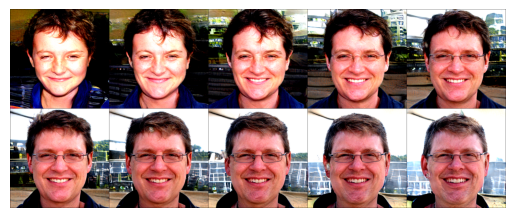

In [ ]:
plt.imshow(grid_img2.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()